# Setup

In [3]:
!pip install -r requirements.txt

In [4]:
import logging
import time
import pathlib
import os
import re

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow_text as tf_text

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("Using CPU")

1 Physical GPUs, 1 Logical GPUs


# Handle data

## Get Vietnamese text and clean up raw data

Please run [Vietnamese_dataset](./Vietnamese_dataset.ipynb) notebook to generate `vn-news-unicode.txt` file first.

## Convert unicode data to ascii

In [6]:
#DATASET_NAME = "truyen-kieu"
DATASET_NAME = "vn-news"
pwd = pathlib.Path.cwd()
dateset_path = pwd / f"{DATASET_NAME}-ds"
uni_file_path = pwd/f"{DATASET_NAME}-unicode.txt"
asc_file_path = pwd/ f"{DATASET_NAME}-ascii.txt"

Reuse `utoa` to convert to ascii text.

In [7]:
%%bash -s "$uni_file_path" "$asc_file_path"
chmod +x ./utoa
if [ ! -f $2 ]; then
    echo "Generating $2"
    ./utoa "$1" > "$2"
fi

Generating /content/vn-news-ascii.txt


## Create dataset from converted text

In [8]:
def source_file_to_dataset():
    uni_file_ds = tf.data.TextLineDataset(uni_file_path)
    asc_file_ds = tf.data.TextLineDataset(asc_file_path)
    atou_ds = tf.data.Dataset.zip(asc_file_ds, uni_file_ds)
    tf.data.Dataset.save(atou_ds, str(dateset_path))
    return atou_ds

def load_dataset():
    if os.path.exists(dateset_path):
        return tf.data.Dataset.load(str(dateset_path))
    return source_file_to_dataset()

In [9]:
ds = load_dataset()

In [10]:
for asc, uni  in ds.take(4): # Take the first 3 pairs
    print(f"Input: {asc.numpy().decode('utf-8')}")

    print(f"Label:  {uni.numpy().decode('utf-8')}")

    print("-" * 10)

Input: Sau do, doi tuong mang so vang vua cuop duoc vut ra via he roi di bo den khu vuc cau Gia Hoi, cach khu vuc gay an khoang 300m
Label:  Sau đó, đối tượng mang số vàng vừa cướp được vứt ra vỉa hè rồi đi bộ đến khu vực cầu Gia Hội, cách khu vực gây án khoảng 300m
----------
Input: Hang tram tieu thuong trong cho Dong Ba va nguoi dan gan cau Gia Hoi duoc yeu cau di chuyen khoi hien truong, dong cua nha de phong dan lac
Label:  Hàng trăm tiểu thương trong chợ Đông Ba và người dân gần cầu Gia Hội được yêu cầu di chuyển khỏi hiện trường, đóng cửa nhà đề phòng đạn lạc
----------
Input: Tuy nhien, thay vang bi nem ra duong, nhieu nguoi dua nhau nhat, tao canh nhon nhao truoc cong cho
Label:  Tuy nhiên, thấy vàng bị ném ra đường, nhiều người đua nhau nhặt, tạo cảnh nhốn nháo trước cổng chợ
----------
Input: Doi tuong lai yeu cau duoc noi chuyen voi Dai ta Dang Ngoc Son, Pho Giam doc Cong an tinh
Label:  Đối tượng lại yêu cầu được nói chuyện với Đại tá Đặng Ngọc Sơn, Phó Giám đốc Công an tỉ

## Build vocabulary and tokenizer

Reference [Subword tokenizers](https://www.tensorflow.org/text/guide/subwords_tokenizer) example.

In [11]:
ds.cardinality().numpy()

np.int64(-2)

In [12]:
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [13]:
atou_ds = ds

In [14]:
asc_ds = ds.map(lambda asc, _: asc)
uni_ds = ds.map(lambda _, uni: uni)

In [15]:
bert_tokenizer_params=dict(
    lower_case=False,
    normalization_form='NFC',
)
reserved_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]

bert_vocab_args = dict(
    # The target vocabulary size
    vocab_size = 8000,
    # Reserved tokens that must be included in the vocabulary
    reserved_tokens=reserved_tokens,
    # Arguments for `text.BertTokenizer`
    bert_tokenizer_params=bert_tokenizer_params,
    # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
    learn_params={},
)

In [16]:
def build_vocab(dataset):
    new_vocab = bert_vocab.bert_vocab_from_dataset(
        dataset.batch(1000).prefetch(2),
        **bert_vocab_args
    )
    print(new_vocab[:10])
    print(new_vocab[100:110])
    print(new_vocab[1000:1010])
    print(new_vocab[-10:])
    return new_vocab

def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [17]:
uni_vocab = build_vocab(uni_ds)

['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '0', '1', '2', '3']
['ý', 'Ă', 'ă', 'Đ', 'đ', 'ĩ', 'ũ', 'Ơ', 'ơ', 'Ư']
['chắc', 'màn', '##t', 'Sơn', 'lớp', 'CLB', 'sẵn', 'nhẹ', 'Long', 'lái']
['##ủ', '##Ứ', '##Ừ', '##Ử', '##ử', '##ữ', '##Ự', '##Ỷ', '##ỷ', '##ỹ']


In [18]:
asc_vocab = build_vocab(asc_ds)

['[PAD]', '[UNK]', '[START]', '[END]', '!', ',', '0', '1', '2', '3']
['so', 've', 'quan', 'thu', 'nam', 'chi', 'den', 'con', 'qua', 'nhieu']
['ruot', 'kin', 'mung', 'Hanh', 'doa', 'thep', 'Trinh', 'chot', 'lot', 'om']
['sneaker', 'tiktoker', 'topping', 'trendy', 'truan', 'type', 'xiem', '##!', '##,', '##_']


Save vocabulary to files

In [19]:
asc_vocab_file = f'{DATASET_NAME}-asc-vocab.txt'
uni_vocab_file = f'{DATASET_NAME}-uni-vocab.txt'
write_vocab_file(asc_vocab_file, asc_vocab)
write_vocab_file(uni_vocab_file, uni_vocab)

Create custom Tokenizer for asc-uni.

In [20]:
START = tf.argmax(tf.constant(reserved_tokens) == "[START]")
END = tf.argmax(tf.constant(reserved_tokens) == "[END]")

def add_start_end(ragged):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START)
  ends = tf.fill([count,1], END)
  return tf.concat([starts, ragged, ends], axis=1)

def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = tf_text.BertTokenizer(vocab_path, **bert_tokenizer_params)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:

    # Include a tokenize signature for a batch of strings.
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)
    enc = add_start_end(enc)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)


In [21]:
model_name = f'{DATASET_NAME}_asc_uni_converter'.replace('-', '_')

tokenizers = tf.Module(model_name)
tokenizers.asc = CustomTokenizer(reserved_tokens, asc_vocab_file)
tokenizers.uni = CustomTokenizer(reserved_tokens, uni_vocab_file)

In [22]:
tokens = tokenizers.uni.tokenize(['Thanh minh trong tiết tháng ba, lễ là tảo mộ hội là đạp thanh!'])
tokens.numpy()

array([[   2,  730,  698,  196,  592,  344,  878,    5, 1184,  190, 4726,
         897,  324,  190, 2239,  582,    4,    3]])

In [23]:
round_trip = tokenizers.uni.detokenize(tokens)
print(round_trip.numpy()[0].decode('utf-8'))

Thanh minh trong tiết tháng ba , lễ là tảo mộ hội là đạp thanh !


## Build the tokenizer

In [24]:
num_lines = int(ds.cardinality().numpy())
train_split_fraction = 0.9 # Use 80% for training
test_split_fraction = 1.0 - train_split_fraction # Use 20% for testing

In [25]:
# Calculate the number of samples for training
train_size = int(train_split_fraction * num_lines)
# The remaining samples will be for testing
test_size = num_lines - train_size
display(num_lines, train_size, test_size)

-2

-1

-1

In [26]:
lengths = []

for asc, uni in atou_ds.batch(1024):
    asc_tokens = tokenizers.asc.tokenize(asc)
    lengths.append(asc_tokens.row_lengths())

    uni_tokens = tokenizers.uni.tokenize(uni)
    lengths.append(uni_tokens.row_lengths())
    print('.', end='', flush=True)

........................................................................................................................................................................................................................................

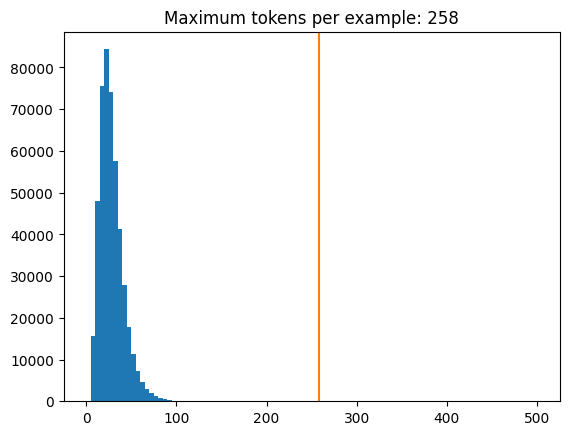

In [27]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

In [28]:
MAX_TOKENS=int(np.percentile(all_lengths, 95))
print(MAX_TOKENS)
def prepare_batch(asc, uni):
    asc = tokenizers.asc.tokenize(asc)      # Output is ragged.
    asc = asc[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    asc = asc.to_tensor()  # Convert to 0-padded dense Tensor

    uni = tokenizers.uni.tokenize(uni)
    uni = uni[:, :(MAX_TOKENS+1)]
    uni_inputs = uni[:, :-1].to_tensor()  # Drop the [END] tokens
    uni_labels = uni[:, 1:].to_tensor()   # Drop the [START] tokens

    return (asc, uni_inputs), uni_labels

53


In [29]:
BATCH_SIZE = 200
BUFFER_SIZE = num_lines
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE, seed=42)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [30]:
shuffled_ds = atou_ds.shuffle(buffer_size=num_lines, seed=42)
train_ds = shuffled_ds.take(train_size) #
test_ds = shuffled_ds.skip(train_size)
print("\nSample from Training Set:")
for asc , uni  in train_ds.take(2):
    print(f"  Input: {asc.numpy().decode('utf-8')} | Label: {uni.numpy().decode('utf-8')}")

print("\nSample from Test Set:")
for asc, uni in test_ds.take(2):
    print(f"  Input: {asc.numpy().decode('utf-8')} | Label: {uni.numpy().decode('utf-8')}")


Sample from Training Set:
  Input: Thu Steve Jobs ap dung vao khi thuyet trinh la thien | Label: Thứ Steve Jobs áp dụng vào khi thuyết trình là thiền
  Input: Sau do anh duoc chan doan la gay xuong don, phai ngoi xe lan va deo mat na duong khi tren duong den benh vien dieu tri | Label: Sau đó anh được chẩn đoán là gãy xương đòn, phải ngồi xe lăn và đeo mặt nạ dưỡng khí trên đường đến bệnh viện điều trị

Sample from Test Set:


In [31]:
# Create training and validation set batches.
train_batches = make_batches(train_ds)
val_batches = make_batches(test_ds)

# Define components

## The embedding and positional encoding layer

In [32]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (5000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 256)


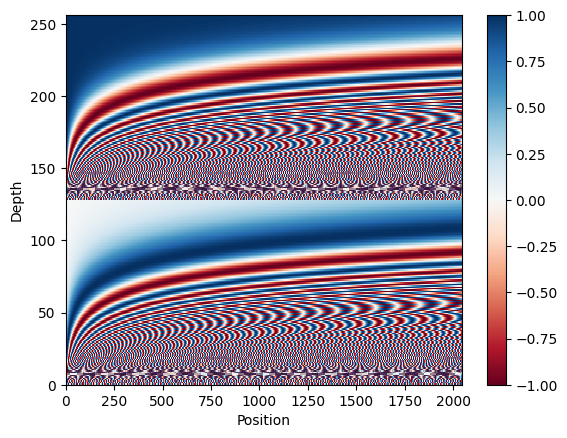

In [33]:
pos_encoding = positional_encoding(length=2048, depth=256)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

(0.0, 1.0)

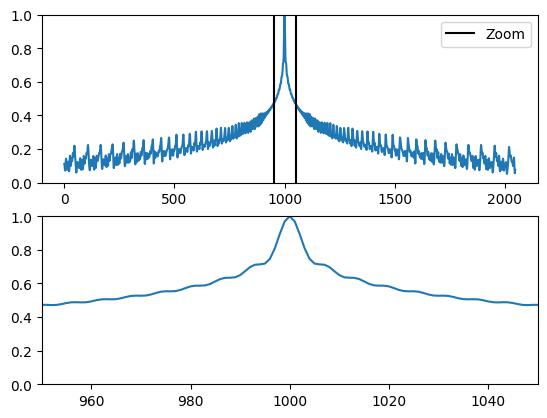

In [34]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [35]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [36]:
for (asc, uni), uni_labels in train_batches.take(1):
  break

print(asc.shape)
print(uni.shape)
print(uni_labels.shape)

(200, 53)
(200, 53)
(200, 53)


In [37]:
print(uni[0][:10])
print(uni_labels[0][:10])

tf.Tensor([  2 595 206 190 305 200 372 331 593 738], shape=(10,), dtype=int64)
tf.Tensor([595 206 190 305 200 372 331 593 738 226], shape=(10,), dtype=int64)


In [38]:
embed_asc = PositionalEmbedding(vocab_size=tokenizers.asc.vocab_size().numpy(), d_model=512)
embed_uni = PositionalEmbedding(vocab_size=tokenizers.uni.vocab_size().numpy(), d_model=512)

In [39]:
asc_emb = embed_asc(asc)
uni_emb = embed_uni(uni)

## Add and normalize

![image.png](attachment:7683b1bc-f7c9-46dc-87d5-c0b2e52cc50b.png)![image.png](attachment:517eedab-1c82-4d44-b3c7-f35d0f1501e2.png)

In [40]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

## The cross attention layer
At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model.

![image.png](attachment:44a3f7df-54db-4f3d-82c5-9404240ad8d6.png)![image.png](attachment:a61dcfbe-bb09-4c01-b809-29906b82fc97.png)


In [41]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [42]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(asc_emb.shape)
print(uni_emb.shape)
print(sample_ca(uni_emb, asc_emb).shape)

(200, 53, 512)
(200, 53, 512)
(200, 53, 512)


## The global self-attention layer
![image.png](attachment:f3377969-efd0-4476-b5f4-4230203fb443.png)![image.png](attachment:3e281ada-9fe4-480e-b2d8-5918bed76756.png)

In [43]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [44]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(asc_emb.shape)
print(sample_gsa(asc_emb).shape)

(200, 53, 512)
(200, 53, 512)


## The causal self-attention layer
![image.png](attachment:b2baf5d0-96d2-451e-aa8f-781bffee67ba.png)![image.png](attachment:04ffe1ed-d48f-4de2-a464-5fdc371b01aa.png)

In [45]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [46]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(uni_emb.shape)
print(sample_csa(uni_emb).shape)


(200, 53, 512)
(200, 53, 512)


## The feed forward network
![image.png](attachment:f38ebfbe-e954-4c74-b85d-8825ea835c56.png)![image.png](attachment:6e971dca-1998-4e18-8dae-9740ca4505d4.png)

In [47]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [48]:
sample_ffn = FeedForward(512, 2048)

print(uni_emb.shape)
print(sample_ffn(uni_emb).shape)


(200, 53, 512)
(200, 53, 512)


## The encoder layer
![image.png](attachment:ca4f8da8-20a4-42d5-94b9-e63b50f3708a.png)

In [49]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [50]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(asc_emb.shape)
print(sample_encoder_layer(asc_emb).shape)


(200, 53, 512)
(200, 53, 512)


## The encoder
![image.png](attachment:4edffadc-372c-43e2-9e37-54919d647a00.png)

In [51]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.


In [52]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(asc, training=False)

# Print the shape.
print(asc.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.


(200, 53)
(200, 53, 512)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_2' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_1' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


## The decoder layer
![image.png](attachment:91700f69-bb2c-4447-856e-c68659234b66.png)

In [53]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x


In [54]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=uni_emb, context=asc_emb)

print(uni_emb.shape)
print(asc_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(200, 53, 512)
(200, 53, 512)
(200, 53, 512)


## The decoder
![image.png](attachment:5332a536-dda4-456f-8324-27738fbf0c0f.png)

In [55]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x


In [56]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=uni,
    context=asc_emb)

# Print the shapes.
print(uni.shape)
print(asc_emb.shape)
print(output.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_2' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'decoder_layer_1' (of type DecoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(200, 53)
(200, 53, 512)
(200, 53, 512)


In [57]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([200, 8, 53, 53])

## The Transformer
To complete the Transformer model, you need to put them together and add a final linear (Dense) layer which converts the resulting vector at each location into output token probabilities.

The output of the decoder is the input to this final linear layer.

![image.png](attachment:22184b58-ac65-4154-80fe-411237893092.png)

In [58]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits


In [59]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [60]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.asc.vocab_size().numpy(),
    target_vocab_size=tokenizers.uni.vocab_size().numpy(),
    dropout_rate=dropout_rate)


In [61]:
output = transformer((asc, uni))

print(uni.shape)
print(asc.shape)
print(output.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

(200, 53)
(200, 53)
(200, 53, 7909)


In [62]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(200, 8, 53, 53)


# Training
It's time to prepare the model and start training it.

## Set up the optimizer

In [63]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [64]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


Text(0.5, 0, 'Train Step')

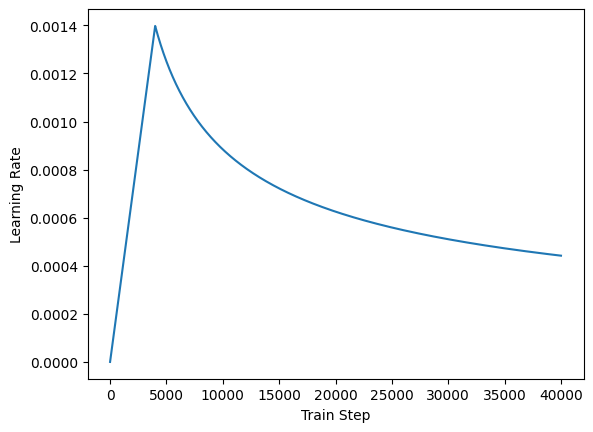

In [65]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Set up the loss and metrics

In [66]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [67]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [68]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
   1184/Unknown 465s 353ms/step - loss: 7.4173 - masked_accuracy: 0.1042

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 467s 355ms/step - loss: 7.4157 - masked_accuracy: 0.1043
Epoch 2/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 442s 372ms/step - loss: 1.4553 - masked_accuracy: 0.7397
Epoch 3/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 469s 345ms/step - loss: 0.6536 - masked_accuracy: 0.8587
Epoch 4/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.4224 - masked_accuracy: 0.9000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1184/1184 ━━━━━━━━━━━━━━━━━━━━ 431s 363ms/step - loss: 0.4224 - masked_accuracy: 0.9000
Epoch 5/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 407s 343ms/step - loss: 0.2245 - masked_accuracy: 0.9407
Epoch 6/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 442s 372ms/step - loss: 0.1598 - masked_accuracy: 0.9567
Epoch 7/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 442s 372ms/step - loss: 0.1256 - masked_accuracy: 0.9655
Epoch 8/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 466s 342ms/step - loss: 0.1020 - masked_accuracy: 0.9717
Epoch 9/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 407s 343ms/step - loss: 0.0870 - masked_accuracy: 0.9759
Epoch 10/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 442s 372ms/step - loss: 0.0736 - masked_accuracy: 0.9795
Epoch 11/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 406s 341ms/step - loss: 0.0641 - masked_accuracy: 0.9821
Epoch 12/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 406s 342ms/step - loss: 0.0555 - masked_accuracy: 0.9844
Epoch 13/20
1184/1184 ━━━━━━━━━━━━━━━━━━━━ 442s 342ms/step - loss: 0.0482 - masked_accuracy: 0.9865
Epoch 14/20
1184/

## Run inference
The following steps are used for inference:

- Encode the input sentence using the ASCII tokenizer (tokenizers.asc). This is the encoder input.
- The decoder input is initialized to the [START] token.
- Calculate the padding masks and the look ahead masks.
- The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
- Concatenate the predicted token to the decoder input and pass it to the decoder.
- In this approach, the decoder predicts the next token based on the previous tokens it predicted.


In [69]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is ASC, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.asc.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.uni.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.uni.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.uni.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights


In [70]:
translator = Translator(tokenizers, transformer)

In [71]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')


In [72]:
sentence = 'Thuyen tinh vua ghe toi noi'
ground_truth = 'Thuyền tình vừa ghé tới nơi'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/us

Input:         : Thuyen tinh vua ghe toi noi
Prediction     : Thuyền tỉnh vừa ghé tới nơi
Ground truth   : Thuyền tình vừa ghé tới nơi


In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [74]:
export_translator = ExportTranslator(translator)
export_translator('hom nay thoi tiet ba mien co nang nong, nhiet do trung binh tren 30 do C.').numpy().decode()

'hôm nay thời tiết bà miễn có nắng nóng , nhiệt độ trung bình trên 30 độ CBQ'

In [75]:
tf.saved_model.save(obj=export_translator, export_dir='translator')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_self_attention_6' (of type GlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'encoder_layer_5' (of type EncoderLayer) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'causal_self_attention_6' (of type CausalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the 

In [76]:
reload_translator = tf.saved_model.load('translator')
reload_translator('hom nay thoi tiet ba mien co nang nong, nhiet do trung binh tren 30 do C.').numpy().decode()

'hôm nay thời tiết bà miễn có nắng nóng , nhiệt độ trung bình trên 30 độ CBQ'

In [77]:
! zip -r translator.zip translator/

  adding: translator/ (stored 0%)
  adding: translator/variables/ (stored 0%)
  adding: translator/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: translator/variables/variables.index (deflated 79%)
  adding: translator/saved_model.pb (deflated 67%)
  adding: translator/fingerprint.pb (stored 0%)
  adding: translator/assets/ (stored 0%)
  adding: translator/assets/vn-news-uni-vocab.txt (deflated 45%)
  adding: translator/assets/vn-news-asc-vocab.txt (deflated 42%)


In [79]:
from google.colab import files
files.download('translator.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>